In [30]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data as web # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import yfinance as yf
import datetime as dt # For defining dates
import mplfinance as mpf # Matplotlib finance

## Function that Saves Stock Data to CSV

In [37]:
# Function that gets a dataframe by providing a ticker and starting date
def save_to_csv_from_yahoo(ticker, syear, smonth, sday, eyear, emonth, eday):
    
    # Defines the time periods to use
    start = dt.datetime(syear, smonth, sday)
    end = dt.datetime(eyear, emonth, eday)
    
    # Reads data into a dataframe
    df = yf.download(ticker, start=start, end=end)
    # Save data to a CSV file
    df.to_csv("C:/Users/91909/Desktop/Python for fin.py/py.finance/" + ticker + '.csv')
    return df

## Function that Returns a Dataframe from a CSV

In [40]:
# Reads a dataframe from the CSV file, changes index to date and returns it
def get_df_from_csv(ticker):
    
    # Try to get the file and if it doesn't exist issue a warning
    try:
        # For Windows
        df = pd.read_csv("C:/Users/91909/Desktop/Python for fin.py/py.finance/" + ticker + '.csv')
    except FileNotFoundError:
        print("File Doesn't Exist")
    else:
        return df

## Add Daily Return to Dataframe

In [86]:
# We calculate a percentage rate of return for each day to compare investments.
# Simple Rate of Return = (End Price - Beginning Price) / Beginning Price OR (EP / BP) - 1

# Shift provides the value from the previous day
# NaN is displayed because there was no previous day price for the 1st calculation
def add_daily_return_to_df(df, ticker):
    # Convert 'Close' to float (safely, in case it's not already)
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
    
    # Calculate daily return without using deprecated fill_method
    df['daily_return'] = df['Close'].pct_change(fill_method=None)
     # Reset index to make 'Date' a column
    df = df.reset_index()

    # Save updated DataFrame to CSV
    df.to_csv("C:/Users/91909/Desktop/Python for fin.py/py.finance/" + ticker + '.csv', index=True)
    
    return df 

## Returns Total Return over Time

In [110]:
def get_return_defined_time(df, syear, smonth, sday, eyear, emonth, eday):
    start = f"{syear}-{smonth:02d}-{sday:02d}"
    end = f"{eyear}-{emonth:02d}-{eday:02d}"

    # Reset index to make the date a column
    df = df.copy().reset_index()

    # Rename the 'index' column to 'Date' for clarity
    df.rename(columns={'index': 'Date'}, inplace=True)

    # Convert the 'Date' column to datetime
    df['Date'] = pd.to_datetime(df['Date'])

    # Filter data between start and end dates
    mask = (df['Date'] >= start) & (df['Date'] <= end)
    df_filtered = df.loc[mask]

    if df_filtered.empty:
        return 0  # or raise an exception
    
    start_price = df_filtered.iloc[0]['Close']
    end_price = df_filtered.iloc[-1]['Close']
    
    return (end_price - start_price) / start_price


## Matplotlib Finance

In [49]:
# Receives a ticker and the date range for which to plot
def mplfinance_plot(ticker, chart_type, syear, smonth, sday, eyear, emonth, eday):
    # Create string representations for the dates
    start = f"{syear}-{smonth}-{sday}"
    end = f"{eyear}-{emonth}-{eday}"
    
    try:
        # For Windows
        df = pd.read_csv('C:/Users/91909/Desktop/Python for fin.py/py.finance/' + ticker + '.csv',index_col=0,parse_dates=True)
    except FileNotFoundError:
        print("File Doesn't Exist")
    else:
        
        # Set data.index as DatetimeIndex
        df.index = pd.DatetimeIndex(df['Date'])
        
        # Define to only use data between provided dates
        df_sub = df.loc[start:end]
        
        # A candlestick chart demonstrates the daily open, high, low and closing price of a stock
        mpf.plot(df_sub,type='candle')

        # Plot price changes
        mpf.plot(df_sub,type='line')

        # Moving averages provide trend information (Average of previous 4 observations)
        mpf.plot(df_sub,type='ohlc',mav=4)
        
        # Define a built in style
        s = mpf.make_mpf_style(base_mpf_style='charles', rc={'font.size': 8})
        # Pass in the defined style to the whole canvas
        fig = mpf.figure(figsize=(12, 8), style=s) 
        # Candle stick chart subplot
        ax = fig.add_subplot(2,1,1) 
        # Volume chart subplot
        av = fig.add_subplot(2,1,2, sharex=ax)  

        # You can plot multiple MAVs, volume, non-trading days
        mpf.plot(df_sub,type=chart_type, mav=(3,5,7), ax=ax, volume=av, show_nontrading=True)

## Simple Price Plot

In [114]:
def price_plot(ticker, syear, smonth, sday, eyear, emonth, eday):
    # Download stock data (ensure you have the correct ticker)
    df = yf.download(ticker, start=f'{syear}-{smonth:02d}-{sday:02d}', end=f'{eyear}-{emonth:02d}-{eday:02d}')
    
    # Print the columns to check if 'Date' exists after resetting the index
    print("Columns after reset:", df.columns)
    
    # Reset index to make the date a column
    df = df.reset_index()

    # Check if 'Date' exists or if it's still 'index'
    if 'Date' not in df.columns:
        df.rename(columns={'index': 'Date'}, inplace=True)
        
    # Convert 'Date' to datetime and set as index
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    
    # Filter data between start and end dates
    start = f"{syear}-{smonth:02d}-{sday:02d}"
    end = f"{eyear}-{emonth:02d}-{eday:02d}"
    df_sub = df.loc[start:end]
    
    # Plot the data (for demonstration purposes)
    df_sub['Close'].plot(title=f"Price Plot for {ticker}")


## Download Multiple Stocks

In [55]:
def download_multiple_stocks(syear, smonth, sday, eyear, emonth, eday, *args):
    for x in args:
        save_to_csv_from_yahoo(x, syear, smonth, sday, eyear, emonth, eday)

## Merge Multiple Stocks in One Dataframe by Column Name

In [58]:
def merge_df_by_column_name(col_name, syear, smonth, sday, eyear, emonth, eday, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()
    
    start = f"{syear}-{smonth}-{sday}"
    end = f"{eyear}-{emonth}-{eday}"
    
    for ticker in tickers:
        df = yf.download(ticker, start=start, end=end)
        mult_df[ticker] = df[col_name]

    return mult_df

## Get Changing Value of Investment using Multiple Stocks

In [74]:
def plot_return_mult_stocks(investment, stock_df):
    (stock_df / stock_df.iloc[0] * investment).plot(figsize = (15,6))


## Get Standard Deviation for Multiple Stocks

Risk is a measure of the variability of return. Variance and Standard Deviation allow us to quantify risk.


Variance is a measure of how spread out a data set is. It is calculated as the average squared deviation of each number from the mean of a data set.n It equals the sum of the squares of the difference between each data point and the mean divided by the number of data points minus 1.

$s^2$ = $\frac{\sum (x - \hat{x})^2}{N - 1}$

Example : If we have 3 annual returns of 23%, -8% and 15%. The mean return is 10%.

* $(23 - 10)^2$ = 169
* $(-8 - 10)^2$ = 324
* $(15 - 10)^2$ = 25
* = 169 + 324 + 25 = 518 / (3-1) = 259 = 2.59

---

Standard deviation is a measure of the amount of variation within a set of values. A low standard deviation indicates that the values tend to be close to the mean. A high standard deviation means values are more spread out. To get the Standard Deviation find the square root of the variance.

$\sqrt{s^2}$ = $\sqrt{2.59}$ = 1.609

In [65]:
# Receives the dataframe with the Adj Close data along with the stock ticker
# Returns the mean and standard deviation associated with the ticker
def get_stock_mean_sd(stock_df, ticker):
    return stock_df[ticker].mean(), stock_df[ticker].std()

In [67]:
# Receives the dataframe with the stock ticker as the column name and
# the Adj Close values as the column data and returns the mean and 
# standard deviation
def get_mult_stock_mean_sd(stock_df):
    for stock in stock_df:
        mean, sd = get_stock_mean_sd(stock_df, stock)
        cov = sd / mean
        print("Stock: {:4} Mean: {:7.2f} Standard deviation: {:2.2f}".format(stock, mean, sd))
        print("Coefficient of Variation: {}\n".format(cov))

## Test Functions

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Total Return : 0
Columns after reset: MultiIndex([( 'Close', 'TATAMOTORS.NS'),
            (  'High', 'TATAMOTORS.NS'),
            (   'Low', 'TATAMOTORS.NS'),
            (  'Open', 'TATAMOTORS.NS'),
            ('Volume', 'TATAMOTORS.NS')],
           names=['Price', 'Ticker'])



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


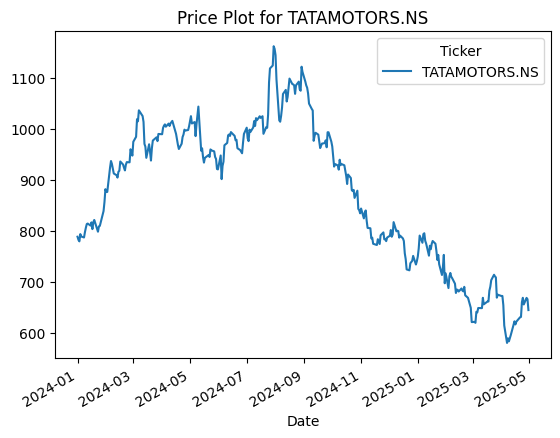

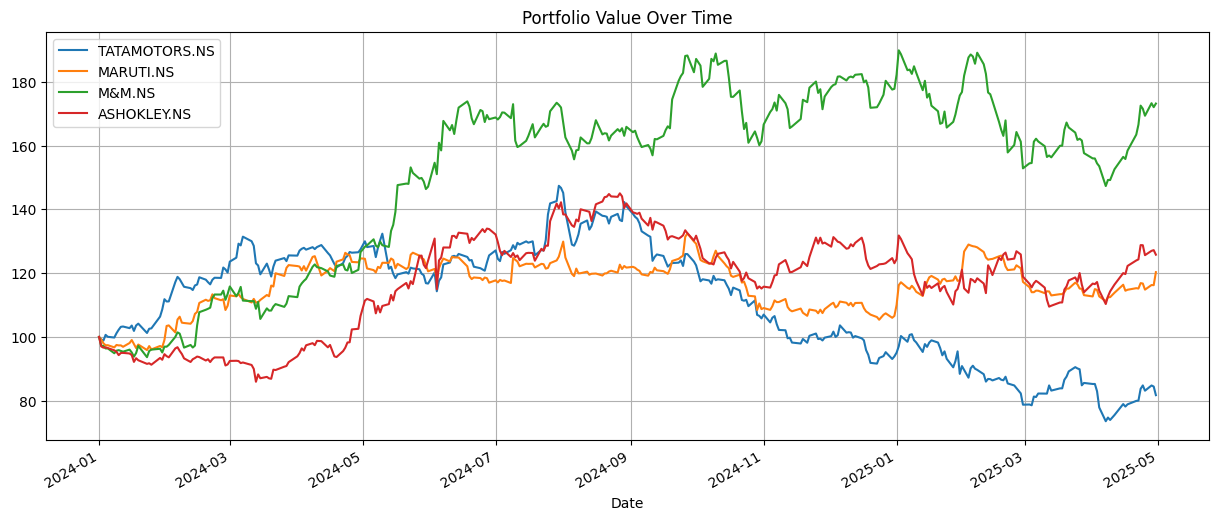

Stock: TATAMOTORS.NS | Mean:  875.03 | Std Dev: 140.10 | Coefficient of Variation: 0.16
Stock: MARUTI.NS  | Mean: 11852.61 | Std Dev: 797.42 | Coefficient of Variation: 0.07
Stock: M&M.NS     | Mean: 2580.30 | Std Dev: 478.64 | Coefficient of Variation: 0.19
Stock: ASHOKLEY.NS | Mean:  209.96 | Std Dev:  27.48 | Coefficient of Variation: 0.13


,TATAMOTORS.NS,MARUTI.NS,M&M.NS,ASHOKLEY.NS
Date,,,,
2024-01-01,788.167725,10187.079102,1690.919067,179.093796
2024-01-02,781.986877,10102.330078,1644.161255,173.748428
2024-01-03,779.045959,9983.354492,1643.218262,173.074249
2024-01-04,793.301941,9921.586914,1629.766724,173.266861
2024-01-05,788.516724,9923.271484,1630.064575,172.833450
...,...,...,...,...
2025-04-24,668.349976,11894.000000,2901.399902,230.619995
2025-04-25,655.250000,11698.000000,2864.199951,225.039993
2025-04-28,668.150024,11846.000000,2930.600098,227.460007


In [120]:
# Call to read the data from Yahoo into a CSV and then retrieve a Dataframe
TM = save_to_csv_from_yahoo('TATAMOTORS.NS',2024, 1, 1, 2025, 5, 1)

# Retrieve data from the CSV file
TM= get_df_from_csv('TATAMOTORS.NS')

# Add daily return to function
add_daily_return_to_df(TM, 'TATAMOTORS.NS')

# Get total return between dates
tot_ret = get_return_defined_time(TM,2024, 1, 1, 2025, 5, 1)
print("Total Return :", tot_ret)

# Use Matplotlib finance to print multiple charts
# mplfinance_plot('TATAMOTORS.NS', 'ohlc', 2020, 6, 1, 2021, 1, 1)

price_plot('TATAMOTORS.NS', 2024, 1, 1, 2025, 5, 1)

# Download multiple stocks
tickers = ["TATAMOTORS.NS", "MARUTI.NS", "M&M.NS", "ASHOKLEY.NS"]
# download_multiple_stocks(2020, 1, 1, 2021, 1, 1, *tickers)

# Merge dataframes from multiple stocks using the same column name
tickers = ["TATAMOTORS.NS", "MARUTI.NS", "M&M.NS", "ASHOKLEY.NS"]
mult_df = merge_df_by_column_name('Close',2024, 1, 1, 2025, 5, 1, *tickers)
mult_df.tail()

# Pass Investment Amount and Plot Returns using Multiple Stocks
plot_return_mult_stocks(100, mult_df)

# Pass multiple stocks with their adjusted close values to receive their
# different means and standard deviations
get_mult_stock_mean_sd(mult_df)
mult_df

# It is hard to compare stocks by standard deviation when their stock prices
# are so different. The coefficient of variation is the ratio between the 
# standard deviation and the mean and it provides a comparable standard deviation
# We get it by dividing the standard deviation by the mean cov = std / mean